# Computation of annotation enrichment in a genetic set 

This code excerpt shows how to use the annotation enrichment computation function in a genetic set.
The funciton return a dataframe of binom and hypergeometric p-value (<= 0.05) and for each p-value a fdr correction with alpha = 0.05.   

In the second part of the code we will compare the results obtained with the Great webserver and between the binomial and hypergeometric probability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
from seaborn import scatterplot as sp

import warnings
warnings.filterwarnings('ignore')

In [3]:
test = "../../data/test/03_srf_hg19.bed"
regdom = "/home/icb/tom.mauger-birocheau/internship/regdom.hg19"
great_out = "../../data/test/03_srf_hg19_output_great_webserver.tsv"
great_asso = "../../data/test/03_srf_hg19_gene_asso.tsv"
size = "/storage/groups/ml01/datasets/annotations/hg19/hg19.chrom.sizes"

## I Compute the p-values

In [4]:
enrichment_tot = great.tl.GREAT.enrichment(
    test_file=test,
    regdom_file=regdom,
    chr_size_file=size,
    annotation_file="../../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    )
great.tl.GREAT.set_bonferroni(enrichment_tot,0.05)
great.tl.GREAT.set_fdr(enrichment_tot,0.05)

,go_term,binom_p_value,hypergeom_p_value,binom_bonferroni,hypergeom_bonferroni,binom_fdr,hypergeom_fdr
GO:0005654,nucleoplasm,9.08310e-15,8.15000e-306,4.07922e-11,3.66016e-302,4.07922e-11,NaN
GO:0072749,cellular response to cytochalasin B,2.22176e-12,1.00000e-308,9.97795e-09,4.49100e-305,3.32598e-09,NaN
GO:0051623,positive regulation of norepinephrine uptake,2.22176e-12,1.00000e-308,9.97795e-09,4.49100e-305,3.32598e-09,NaN
GO:0015629,actin cytoskeleton,9.65326e-12,2.02000e-306,4.33528e-08,9.07182e-303,1.08382e-08,NaN
GO:0051621,regulation of norepinephrine uptake,3.74424e-11,4.00000e-308,1.68154e-07,1.79640e-304,3.36308e-08,NaN
...,...,...,...,...,...,...,...
GO:0015141,succinate transmembrane transporter activity,1.00000e+00,1.00000e-307,1.00000e+00,4.49100e-304,1.00000e+00,NaN
GO:0071422,succinate transmembrane transport,1.00000e+00,8.00000e-308,1.00000e+00,3.59280e-304,1.00000e+00,NaN
GO:0015116,sulfate transmembrane transporter activity,1.00000e+00,2.30000e-307,1.00000e+00,1.03293e-303,1.00000e+00,NaN
GO:0003680,AT DNA binding,1.00000e+00,1.70000e-307,1.00000e+00,7.63470e-304,1.00000e+00,NaN


## II Compare to GREAT webserver  

### II.1 Import the data

In [5]:
great_webserver = pd.read_csv(great_out,sep="\t",comment="#",
                    names=["ontologie","term_name","ID","binom_p_value","binom_bonferroni","binom_fdr","hyper_p_value","hyper_bonferroni","hyper_fdr"],index_col=False,
                    dtype={"term_name":"object", "ID":"object","binom_p_value":"float64", "binom_bonferroni":"float64", "binom_fdr":"float64", "hyper_p_value":"float64", "hyper_bonferroni":"float64", "hyper_fdr":"float64"})
great_webserver.rename(columns={"ID":"id"},inplace=True)
del great_webserver["ontologie"]
del great_webserver["term_name"]

In [6]:
great_webserver

,id,binom_p_value,binom_bonferroni,binom_fdr,hyper_p_value,hyper_bonferroni,hyper_fdr
0,GO:0098974,3.51315e-12,4.61804e-08,4.61804e-08,4.26438e-02,1.00000e+00,1.00000e+00
1,GO:0032796,4.25834e-09,5.59758e-05,2.79879e-05,1.81629e-03,1.00000e+00,2.56722e-01
2,GO:0070527,3.67269e-08,4.82775e-04,1.60925e-04,2.66655e-02,1.00000e+00,8.91905e-01
3,GO:0038094,1.39674e-07,1.83602e-03,4.59005e-04,8.37779e-05,1.00000e+00,4.07874e-02
4,GO:1903919,1.50542e-07,1.97888e-03,3.95775e-04,4.26438e-02,1.00000e+00,1.00000e+00
...,...,...,...,...,...,...,...
338,GO:0070119,3.23390e-02,1.00000e+00,1.00000e+00,4.26438e-02,1.00000e+00,1.00000e+00
339,GO:0051959,3.37217e-02,1.00000e+00,1.00000e+00,7.05500e-03,1.00000e+00,7.08692e-01
340,GO:0047224,3.81319e-02,1.00000e+00,1.00000e+00,4.26438e-02,1.00000e+00,1.00000e+00
341,GO:0048531,3.95004e-02,1.00000e+00,1.00000e+00,2.85627e-02,1.00000e+00,1.00000e+00


### II.2 Compare the results between greatpy and great 

#### II.2.1 Preprocessing

In [7]:
before_pp = enrichment_tot.shape[0]
enrichment_tot = enrichment_tot[enrichment_tot.index.isin(list(great_webserver["id"]))]
after_pp = enrichment_tot.shape[0]

In [8]:
great_webserver = great_webserver[great_webserver["id"].isin(list(enrichment_tot.index))]
great_webserver = great_webserver.sort_values("id")

In [9]:
binom_greatpy = hyper_greatpy = binom_great = hyper_great = []
for i in range(enrichment_tot.shape[0]) : 
    go_id = list(enrichment_tot.index)[i]
    curr_enrichment = enrichment_tot.iloc[i]
    curr_great_webserver = great_webserver.loc[great_webserver["id"]==go_id]
    binom_greatpy.append(float(curr_enrichment["binom_p_value"]))
    hyper_greatpy.append(float(curr_enrichment["hypergeom_p_value"]))
    binom_great.append(float(curr_great_webserver["binom_p_value"]))
    hyper_great.append(float(curr_great_webserver["hyper_p_value"]))
binom = pd.DataFrame({"binom_greatpy":binom_greatpy,"binom_great":binom_great})
hyper = pd.DataFrame({"hyper_greatpy":hyper_greatpy,"hyper_great":hyper_great})

#### II.2.b Graphical

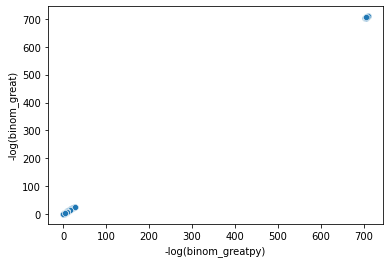

In [10]:
pl=great.pl.scatterplot(binom,colname_x="binom_greatpy",colname_y="binom_great")

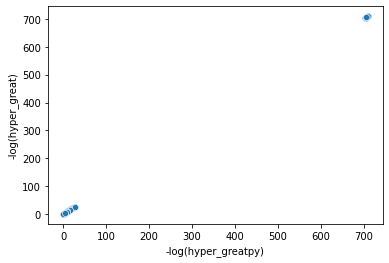

In [11]:
great.pl.scatterplot(hyper,colname_x="hyper_greatpy",colname_y="hyper_great")

#### II.2.c Statistics

In [12]:
def stat(binom_great_list_list, hyper_great_listpy_list,binom_great_list,hyper_great_list) : 
    if len(binom_great_list_list) >= 2 and len(hyper_great_listpy_list) >= 2 and len(binom_great_list) >= 2  and len(hyper_great_list) >= 2 : 
        return pd.DataFrame({
            "binom": [cov(m = binom_great_list_list, y = binom_great_list)[0][1],pearsonr(binom_great_list_list,binom_great_list)[0]],
            "hyper":[cov(m = hyper_great_listpy_list, y = hyper_great_list)[0][1],pearsonr(hyper_great_listpy_list,hyper_great_list)[0]]},
            index=["correlation_coefficient","pearson"])
    return False

Issue is : NaN in hyper_fdr

In [13]:
# stat(binom_greatpy, hyper_greatpy,binom_great,hyper_great)

In [14]:
print(before_pp)
print(after_pp)

4491
246


We went from 268 ontology terms in greatpy output to 92 ontology terms by selecting the GO identifiers present in both greatpy and great 

But when two ontology terms are selected they have the same binomial and hypergeometric probability value 

# How many associations are good or bad 

In [15]:
gene_asso_great = pd.read_csv(great_asso,sep="\t",comment="#",names=["ontologies","gene"],index_col=False, dtype={"ontologies":"object","gene":"object"},usecols=["gene"])
gene_asso_greatpy = great.tl.get_association(
    test = pd.read_csv(test,sep="\t",comment="#",usecols=[0,1,2],names=["Chr", "Chr_Start", "Chr_End"],dtype={"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64"}),
    regdom= pd.read_csv(regdom,sep="\t",comment="#",names=["Chr", "Chr_Start", "Chr_End","Name","tss","Strand"],dtype={"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64","Name":"object","tss":"int64","Strand":"object"}))
in_in = gene_asso_great[gene_asso_great["gene"].isin(gene_asso_greatpy)].shape[0]
in_out = [i for i in list(gene_asso_great["gene"]) if i not in gene_asso_greatpy]
out_in = [i for i in gene_asso_greatpy if i not in list(gene_asso_great["gene"])]

print(f"Number of gene association present in greatpy and great : {in_in}")
print(f"Number of gene association prensent in great and not in greatpy {len(in_out)}")
print(f"Number of gene association prensent in greatpy and not in great {len(out_in)}")

Number of gene association present in greatpy and great : 410
Number of gene association prensent in great and not in greatpy 123
Number of gene association prensent in greatpy and not in great 623
